# INSAT-3D Next-Day Forecasting (PyTorch + GPU)
**Overview**  
- Load INSAT-3D channels (VIS, MIR, SWIR, WV, TIR1) for March 10–31 @00:15  
- Convert DN→physical with **h5py**, downsample to 256×256  
- Build a PyTorch `Dataset` & `DataLoader`  
- Train a simple CNN on **GPU** to predict day N+1 from day N  
- Save & resume checkpoints  
- Visualize training loss and final ORIGINAL vs PREDICTED  


In [2]:
# %% 
# Cell 1: Imports & GPU setup

# install missing packages
%pip install tensorflow

import os, glob
from datetime import datetime   
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
import matplotlib.pyplot as plt

# Mixed precision for speed
tf.keras.mixed_precision.set_global_policy('mixed_float16')

print(" GPUs available:", tf.config.list_physical_devices('GPU'))

# Configuration
DATA_DIR    = r"C:\college\CV\COSMOS\_data"
CHANNELS    = ['VIS','MIR','SWIR','WV','TIR1']
TARGET_SIZE = (256,256)    # downsample grid
BATCH_SIZE  = 4
EPOCHS      = 20
CKPT_DIR    = "checkpoints"
os.makedirs(CKPT_DIR, exist_ok=True)


  Using cached tensorflow-2.19.0-cp39-cp39-win_amd64.whl.metadata (4.1 kB)
  Using cached absl_py-2.2.2-py3-none-any.whl.metadata (2.6 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-5.29.4-cp39-cp39-win_amd64.whl.metadata (592 bytes)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached wrapt-1.17.2-cp39-cp39-win_amd64.whl.metadata (6.5 kB)
  Using cached grpcio-1.71.0-cp39-cp39-win_amd64.whl.metadata (4.0 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached kera

## Cell 2: Load & Preprocess One File  
- Read DNs → LUT → physical units via **h5py**  
- Downsample each channel to 256×256 with `interpolate`  


In [3]:
# %%
def load_and_preprocess(fp):
    """
    Returns a (256,256,5) float32 array for a single timestamp.
    """
    with h5py.File(fp,'r') as f:
        # read DNs
        dn = { ch: f[f"IMG_{ch}"][0].astype(int) for ch in CHANNELS }
        # read full LUTs
        lut = {
            'VIS':  f['IMG_VIS_ALBEDO'][:],
            'MIR':  f['IMG_MIR_RADIANCE'][:],
            'SWIR': f['IMG_SWIR_RADIANCE'][:],
            'WV':   f['IMG_WV_RADIANCE'][:],
            'TIR1': f['IMG_TIR1_TEMP'][:]
        }

    # apply LUT → list of (H,W) arrays
    bands = [ lut[ch][ dn[ch] ].astype(np.float32) for ch in CHANNELS ]
    stacked = np.stack(bands, axis=-1)  # (H,W,5)

    # downsample
    resized = np.zeros((TARGET_SIZE[0],TARGET_SIZE[1], stacked.shape[-1]), np.float32)
    for i in range(stacked.shape[-1]):
        resized[...,i] = tf.image.resize(
            stacked[...,i][...,None],
            TARGET_SIZE, method='bilinear'
        ).numpy().squeeze()

    return resized

# Quick sanity check on one file
sample_fp = os.path.join(DATA_DIR, "3RIMG_10MAR2025_0015_L1C_SGP_V01R00.h5")
sample = load_and_preprocess(sample_fp)
print("Sample shape:", sample.shape)
for i,ch in enumerate(CHANNELS):
    print(f"  {ch}: min={sample[...,i].min():.3f}, max={sample[...,i].max():.3f}")


Sample shape: (256, 256, 5)
  VIS: min=3.999, max=100.000
  MIR: min=0.000, max=0.346
  SWIR: min=0.000, max=6.700
  WV: min=0.006, max=0.282
  TIR1: min=179.859, max=300.710


## Cell 3: Build the Time-Series Dataset  
- For each day Mar 10→31 pick the 00:15 file  
- Stack into `data` shape `(T,C,H,W)`  
- Create `(X,y)` where `X[n]=day n`, `y[n]=day n+1`  
- Normalize per-channel  


In [12]:
# %%
# assemble daily list
dates = pd.date_range("2025-03-10","2025-03-31",freq='D')
data_list = []
for d in dates:
    tag = d.strftime('%d%b%Y').upper()
    fn = f"3RIMG_{tag}_0015_L1C_SGP_V01R00.h5"
    fp = os.path.join(DATA_DIR, fn)
    if not os.path.exists(fp):
        raise FileNotFoundError(fn)
    data_list.append(load_and_preprocess(fp))

# stack into (T,H,W,C)
arr = np.stack(data_list, axis=0)
X = arr[:-1]
y = arr[1:]

# normalize
mean = X.mean(axis=(0,1,2))
std  = X.std(axis=(0,1,2))
Xn   = (X-mean)/std
yn   = (y-mean)/std

print("Dataset shapes:")
print("  X:", Xn.shape, "y:", yn.shape)
print("Per-channel mean/std:", list(zip(mean, std)))
print("=== COPY THESE INTO app.py ===")
print("MEAN =", mean.tolist())
print("STD  =", std.tolist())



Dataset shapes:
  X: (21, 256, 256, 5) y: (21, 256, 256, 5)
Per-channel mean/std: [(np.float32(9.2491255), np.float32(7.7568088)), (np.float32(0.032553893), np.float32(0.019600494)), (np.float32(0.35804546), np.float32(0.6404346)), (np.float32(0.14131774), np.float32(0.047004)), (np.float32(271.21878), np.float32(20.69616))]
=== COPY THESE INTO app.py ===
MEAN = [9.249125480651855, 0.03255389258265495, 0.35804545879364014, 0.14131774008274078, 271.2187805175781]
STD  = [7.756808757781982, 0.01960049383342266, 0.6404346227645874, 0.04700399935245514, 20.69615936279297]


## Cell 4: PyTorch Dataset & DataLoader  


In [5]:
# %%
ds = (tf.data.Dataset
      .from_tensor_slices((Xn,yn))
      .shuffle(8)
      .batch(BATCH_SIZE)
      .prefetch(tf.data.AUTOTUNE))

# show one batch shapes
for xb,yb in ds.take(1):
    print("Batch X:", xb.shape, "Batch y:", yb.shape)


Batch X: (4, 256, 256, 5) Batch y: (4, 256, 256, 5)


## Cell 5: Model Definition & Summary  
- Simple CNN encoder–decoder  
- Move model to **GPU**  


In [6]:
# %%
def build_model(input_shape):
    inp = layers.Input(input_shape)
    x   = layers.Conv2D(32,3,padding='same',activation='relu')(inp)
    x   = layers.MaxPooling2D()(x)                   # 256→128
    x   = layers.Conv2D(64,3,padding='same',activation='relu')(x)
    x   = layers.Conv2D(128,3,padding='same',activation='relu')(x)
    x   = layers.UpSampling2D()(x)                   # 128→256
    x   = layers.Conv2D(64,3,padding='same',activation='relu')(x)
    x   = layers.Conv2D(32,3,padding='same',activation='relu')(x)
    out = layers.Conv2D(input_shape[-1],1,
                        padding='same',
                        activation='linear',
                        dtype='float32')(x)
    return models.Model(inp,out)

model = build_model((TARGET_SIZE[0],TARGET_SIZE[1],len(CHANNELS)))
model.compile(optimizer=optimizers.Adam(1e-4),
              loss='mse', metrics=['mae'])

model.summary()

# Optional: visualize with pydot (install graphviz & pydot)
# from tensorflow.keras.utils import plot_model
# plot_model(model, show_shapes=True, to_file="model.png")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 5)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast (Cast)                     │ (None, 256, 256, 5)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 256, 256, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 256, 256, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 256, 256, 5)    │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,245 (727.52 KB)

 Trainable params: 186,245 (727.52 KB)

 Non-trainable params: 0 (0.00 B)

## Cell 6: Training Loop with GPU & Checkpoints  


In [7]:
# %%
import glob

# 1) Update checkpoint filename pattern to end in `.weights.h5`
CKPT_PATTERN = os.path.join(CKPT_DIR, "cp-*.weights.h5")

# 2) See if any checkpoints exist
existing = sorted(glob.glob(CKPT_PATTERN))
if existing:
    # grab the last one (highest epoch)
    latest = existing[-1]
    # extract epoch number from filename, e.g. cp-05.weights.h5 → 5
    start_epoch = int(os.path.basename(latest).split('-')[1].split('.')[0])
    model.load_weights(latest)
    print(f"Resuming from epoch {start_epoch}")
else:
    start_epoch = 0
    print("Starting fresh training")

# 3) Create the ModelCheckpoint callback with a valid .weights.h5 extension
cp_cb = callbacks.ModelCheckpoint(
    filepath=os.path.join(CKPT_DIR, "cp-{epoch:02d}.weights.h5"),
    save_weights_only=True,
    save_freq='epoch',
    verbose=1
)

# 4) Kick off training (will resume if start_epoch > 0)
history = model.fit(
    ds,
    initial_epoch=start_epoch,
    epochs=EPOCHS,
    callbacks=[cp_cb]
)


Resuming from epoch 11
Epoch 12/20


c:\Users\dhanu\.conda\envs\insat3d\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\dhanu\.conda\envs\insat3d\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 102s/step - loss: 0.4105 - mae: 0.4145  
Epoch 12: saving model to checkpoints\cp-12.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 642s 102s/step - loss: 0.4099 - mae: 0.4144
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 109s/step - loss: 0.4017 - mae: 0.4061  
Epoch 13: saving model to checkpoints\cp-13.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 678s 109s/step - loss: 0.4017 - mae: 0.4061
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 111s/step - loss: 0.4044 - mae: 0.4110  
Epoch 14: saving model to checkpoints\cp-14.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 678s 111s/step - loss: 0.4033 - mae: 0.4104
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 122s/step - loss: 0.4003 - mae: 0.4041  
Epoch 15: saving model to checkpoints\cp-15.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 743s 122s/step - loss: 0.3993 - mae: 0.4037
Epoch 16/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 100s/step - loss: 0.3976 - mae: 0.4047  
Epoch 16: saving model to checkpoints\cp-16.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 642s 100s/step - loss: 0.3969 -

## Cell 7: Plot Training Loss  


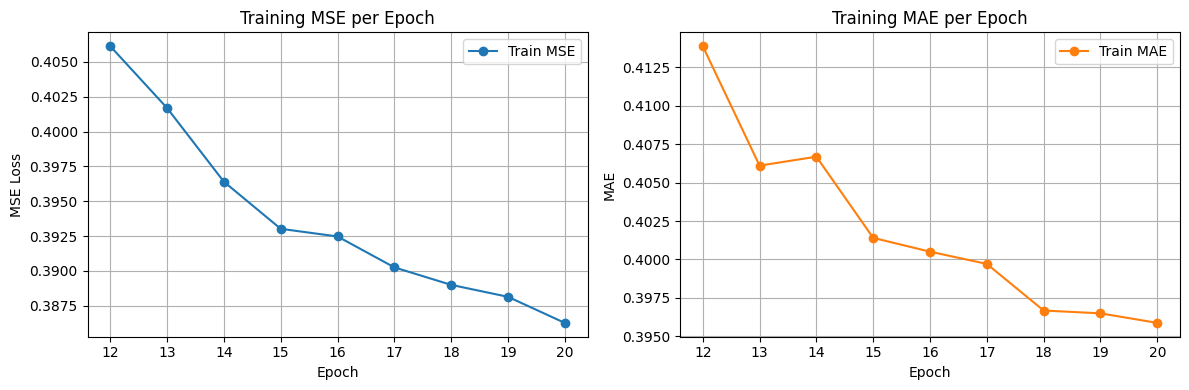

In [10]:
# %%
# extract history
hist = history.history

# history.epoch is a list of epoch indices for this fit() call
# e.g. [0,1,2,...] or [start_epoch, start_epoch+1,...]
epochs = history.epoch

# for display, convert to 1-based epoch numbers
epochs_display = [e + 1 for e in epochs]

plt.figure(figsize=(12,4))

# Plot MSE
plt.subplot(1,2,1)
plt.plot(epochs_display, hist['loss'],  marker='o', label='Train MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training MSE per Epoch')
plt.grid(True)
plt.legend()

# Plot MAE
plt.subplot(1,2,2)
plt.plot(epochs_display, hist['mae'],  marker='o', label='Train MAE', color='tab:orange')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training MAE per Epoch')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## Cell 8: Final Prediction & Visualization  


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
MSE per channel: {'VIS': '12.663', 'MIR': '0.000', 'SWIR': '0.067', 'WV': '0.001', 'TIR1': '254.721'}


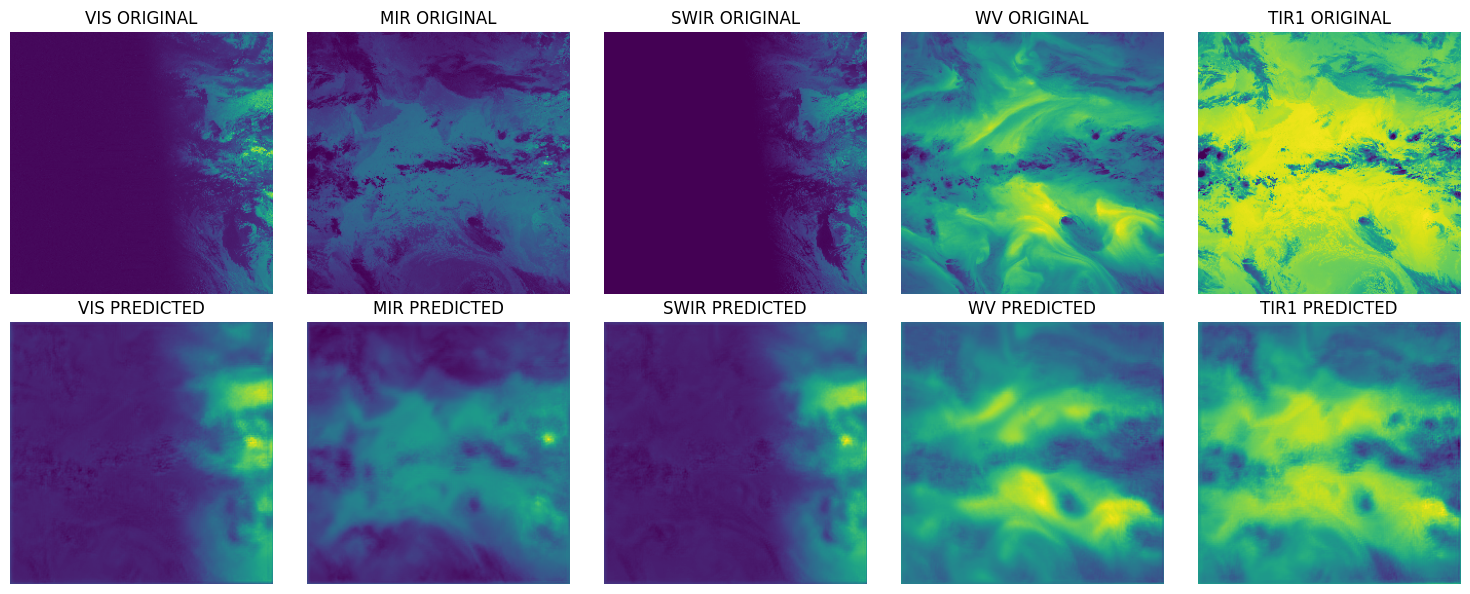

In [11]:
# %%
# prepare input
x_in   = Xn[-1][None]
y_true = y[-1]

# predict & denormalize
y_predn = model.predict(x_in)[0]
y_pred  = y_predn * std + mean

# compute per-channel MSE
mse_per_ch = np.mean((y_true - y_pred)**2, axis=(0,1))
print("MSE per channel:", {ch: f"{mse:.3f}" for ch,mse in zip(CHANNELS, mse_per_ch)})

# plot
fig, axs = plt.subplots(2, len(CHANNELS), figsize=(len(CHANNELS)*3,6))
for i,ch in enumerate(CHANNELS):
    im0 = axs[0,i].imshow(y_true[...,i], cmap='viridis')
    axs[0,i].set_title(f"{ch} ORIGINAL")
    axs[0,i].axis('off')
    im1 = axs[1,i].imshow(y_pred[...,i], cmap='viridis')
    axs[1,i].set_title(f"{ch} PREDICTED")
    axs[1,i].axis('off')

plt.tight_layout()
plt.show()


 ## Cell 9: Save Final Model & Usage
 ```python
 # to save full model
 model.save("final_insat3d_model.h5")

 # to load later:
 from tensorflow.keras.models import load_model
 m = load_model("final_insat3d_model.h5", compile=False)
 ```

 **–– End of Notebook ––**
